<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<font size="5"><b><center>YANDEX MUSIC: CLASSIFICATOR BY TEAM 13</center></b></font>

# Содержание ноутбука

*В данном ноутбуке представлено отбор алгоритмов классификации и выбор итогового.*

# Библиотеки

In [1]:
import os
import pandas as pd
import re

import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm, notebook

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns

import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as textb

from scipy.sparse import csr_matrix, hstack

from sklearn.preprocessing import RobustScaler

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate

import category_encoders as ce
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
notebook.tqdm().pandas()

2023-11-03 02:23:47.464919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0it [00:00, ?it/s]

In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

In [3]:
cwd = os.getcwd() + '/data_after/'
path_merge_data = cwd + 'merge_data.csv'

In [4]:
merge_data = pd.read_csv(path_merge_data, index_col=0)

# Дисбаланс целевого признака

Во время исследования мы выяснили, что баланс целевого признака сильно смещен в сторону негативного (каверов больше). Это может навредить качеству модели, она будет переобучаться. Что бы это исправить , есть нескоько способов:

1. Сократить количество отрицательного класса, но тогда есть шанс потерять часть важных данных.
2. Использовать веса модели, т.е. более редкий класс будет иметь больший вес.
   Но всеравно остается высокая вероятность переобучения модели.
3. Увеличить количество примеров, с меньшим классом.

Выберем последний вариант, так как мы считаем его более приемлимым.

In [5]:
oversampler = RandomOverSampler(sampling_strategy='minority')

features, target = oversampler.fit_resample(merge_data.drop(['track_remake_type'], axis=1),
                                            merge_data['track_remake_type'])

In [6]:
data = pd.concat([features, target], axis=1)
data['track_remake_type'].value_counts(normalize=True)

track_remake_type
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

In [7]:
del features, target

# Подготовка текстов

In [8]:
def save_emb(corpus, name):
    np.save(cwd+f'{name}.npy', corpus)

In [9]:
def load_emb(name):
    corpus = np.load(cwd+f"{name}.npy")
    return corpus

In [10]:
def clear_text(text):
    cleared_text = re.sub(r"[^\w\s\d]|_", " ", text)
    cleared_text =  re.sub(r'\n', " ", cleared_text)
    cleared_text = re.sub("[0-9]+", "", cleared_text)
    return cleared_text

In [11]:
def get_emb(col:str):
    corpus = []
    use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")
    for r in tqdm(data[col].values):
        emb = use(r)
        review_emb = tf.reshape(emb, [-1]).numpy()
        corpus.append(review_emb)
    return corpus

Преобразуем текст песен и названия в векторы.

Предварительно проведем очистку текста от знаков и цифр.

In [12]:
data['title'] = data['title'].progress_apply(clear_text)
data['text'] = data['text'].progress_apply(clear_text)

  0%|          | 0/14036 [00:00<?, ?it/s]

  0%|          | 0/14036 [00:00<?, ?it/s]

Преобразуем текст в векторы и сохраним результат. Для экономии времени дальше будем подгружать уже полученные вектора.

Для обработки будем использовать Multi Universe Sentence Encoder (MUSE), модель для кодирования предложений, разработанная OpenAI. Она позволяет выполнять перенос знаний между языками. Это означает, что можно обучить модель на одном языке и использовать ее знания в другом.

MUSE предоставляет качественные векторные представления для предложений, что делает его полезным инструментом для различных задач обработки естественного языка.

In [13]:
# corpus_title = get_emb('title')
# save_emb(corpus_title, 'corpus_title')
# corpus_text = get_emb('text')
# save_emb(corpus_text, 'corpus_text')

In [14]:
corpus_text = load_emb('corpus_text')
corpus_title = load_emb('corpus_title')

# Численные и категориальные признаки.

Отборосим:
 - track_id, original_track_id - как не информативные
 - dttm, isrc т.к. все нужное было извлечено
 - text и title - обработаны ранее

In [15]:
df_numeric_features = data.drop(['track_id', 'original_track_id', 'dttm', 'text', 'title', 'isrc'], axis=1).copy(deep=True)

In [16]:
df_numeric_features.head()

,language,genres,duration,genres_upd,is_normal_track,is_long_track,word_per_min,num_punct_text,mean_word_length,year_from_isrc,year_from_dttm,country_code,track_remake_type
0,ru,foreignbard bard,2.333333,bard,1,0,7.116667,58,3.762431,2018,2018,ae,1.0
1,en,electronics,3.576500,electronics,0,1,5.305142,12,4.034483,2021,2021,qz,0.0
2,en,rock allrock,5.298500,allrock,0,0,29.494983,21,3.813291,2010,2010,us,1.0
3,en,rock allrock,5.297667,allrock,0,0,29.490344,21,3.813291,2011,2014,us,1.0
4,en,rock allrock,5.354667,allrock,0,0,37.482667,43,4.060302,2010,2010,us,1.0


## Оценка значимости признаков с помощью SelectKBest

SelectKBest -  используется для выбора лучших признаков из набора данных. Параметр score_func определяет функцию, которая используется для оценки важности каждого признака.

<u>Будем использовать:</u>

1. **f_classif:**  для анализа дисперсии (ANOVA) для оценки важности признаков. Он измеряет различия между средними значениями признаков для разных классов и учитывает дисперсию внутри каждого класса. Высокие значения f-статистики указывают на более важные признаки.

2. **chi2:** для анализа критерия "хи-квадрат" для оценки важности категориальных (небинарных) признаков. Он измеряет зависимость между признаком и целевой переменной.

Признак "genres" отбросим, он будет нужен для ранжирования. 

In [17]:
df_numeric_features.drop(['genres'], axis=1, inplace=True)

Бинарные признаки необходимо преобразовтаь в числовые, для того , что бы модель могла с нимим работать.
Посмотрим, сколько значений содержит каждый категориальный признак, и исходя из этого выберем метод кодирования.

In [18]:
def num_val_for_cat_features():
    columns =  df_numeric_features[['track_remake_type', 'language',
                                     'genres_upd', 'country_code']].columns.to_list()
    print('Категориальные признаки:')
    print()
    for col in columns:
        print(f'Колтичество значений в {col} -', df_numeric_features[col].unique().shape[0])

In [19]:
num_val_for_cat_features()

Категориальные признаки:

Колтичество значений в track_remake_type - 2
Колтичество значений в language - 56
Колтичество значений в genres_upd - 24
Колтичество значений в country_code - 73


 - Как и было замечено в исследовании, признаки "language", "country_code",
   "genres_upd" содержат много значений. 
   Их закодируем методами Hashing Encoding и CatBoostEncoder.
   
 - Так же попробуем бинарное кодирование. Не смотря на то, что это сильно увеличит 
   признаковое пространство, но позволит избежать утечки и избыточной связи, 
   как в случае с порядковым кодированием.
   
   Проведем эксперимент, а после выберем лучший вариант.

In [20]:
def show_importance_for_numeric_features():
    target = df_numeric_features['track_remake_type']
    df_num = df_numeric_features.drop(['track_remake_type', 'language',
                                       'genres_upd', 'country_code', 'track_remake_type'], axis=1).copy(deep=True)
    
    scaler = RobustScaler()
    for col in df_num.columns.tolist():
        df_num[col] = scaler.fit_transform(df_num[col].values.reshape(-1, 1))
    plt.figure(figsize=(15, 7))
    sns.set_style('darkgrid')
    plt.title('Числовые признаки', fontsize=12)
    selector = SelectKBest(f_classif, k='all')
    selector.fit(df_num[df_num.columns.to_list()],
                 target)
    scores = -np.log10(selector.pvalues_)
              
    plt.bar(range(len(df_num.columns.to_list())), scores)
              
    plt.xticks(range(len(df_num.columns.to_list())), df_num.columns.to_list(), rotation='vertical')
              
    plt.ylabel('Значения', fontsize=12)
    plt.xlabel('Признаки', fontsize=12)
    plt.grid(True)
    
    plt.show(True);

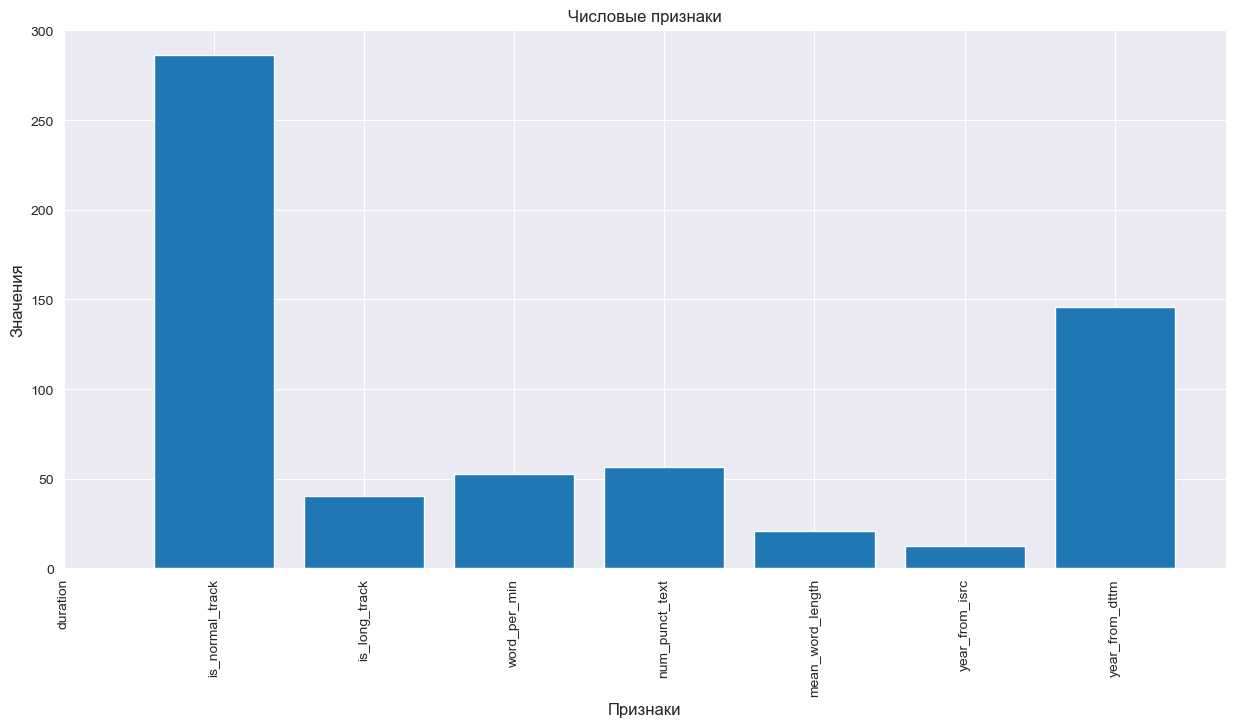

In [21]:
show_importance_for_numeric_features()

 - Для численных признаков значимы: слово в минуту, категория трека normal, месяц года. Длительность трека считается не информативной.

In [22]:
def get_df_by_coders():
    target = df_numeric_features['track_remake_type']
    cat_features = df_numeric_features[['language','genres_upd', 'country_code']]
    
    df_cat_features_binary = pd.get_dummies(cat_features, drop_first=True, dtype=int)
    df_cat_features_cat = ce.CatBoostEncoder().fit_transform(cat_features, target)
    hash_encoder = ce.HashingEncoder()
    df_cat_features_hash = ce.HashingEncoder().fit_transform(cat_features)
    
    df_cat_features_binary = pd.concat([df_cat_features_binary, target], axis=1).astype(int)
    df_cat_features_cat = pd.concat([df_cat_features_cat, target], axis=1)
    df_cat_features_hash = pd.concat([df_cat_features_hash, target], axis=1)
    return df_cat_features_binary, df_cat_features_cat, df_cat_features_hash

In [23]:
%%time
df_cat_features_binary, df_cat_features_cat, df_cat_features_hash = get_df_by_coders()

CPU times: user 185 ms, sys: 197 ms, total: 382 ms
Wall time: 7.24 s


In [24]:
def show_importance_for_cat_features():
    position = 0
    plt.figure(figsize=[20, 15])
    plt.subplots_adjust(top=0.92, wspace=0.5, hspace=0.92)
    sns.set_style('darkgrid')
    plt.suptitle('Сравнение методов кодирования', fontsize=15)
    target = df_numeric_features['track_remake_type']
    for k, df in {"Бинарное кодирование": df_cat_features_binary, 
                  "CatBoostEncoder": df_cat_features_cat, 
                  "HashingEncoder": df_cat_features_hash}.items():
        position += 1
        plt.subplot(3, 1, position)
        plt.title(f'{k}', fontsize=17)
        sns.set_style('darkgrid')
        cat_first = df.drop(['track_remake_type'], axis=1)
        selector = SelectKBest(chi2, k='all')
        selector.fit(cat_first[cat_first.columns.to_list()], target)
        scores_first = -np.log10(selector.pvalues_)              
        plt.bar(range(len(cat_first.columns.to_list())), scores_first)              
        plt.xticks(range(len(cat_first.columns.to_list())), cat_first.columns.to_list(), rotation='vertical')
        plt.ylabel('Значения', fontsize=17)
        plt.xlabel('Признаки', fontsize=17)
        plt.grid(True)
        sns.set_style('darkgrid')

    plt.show(True);

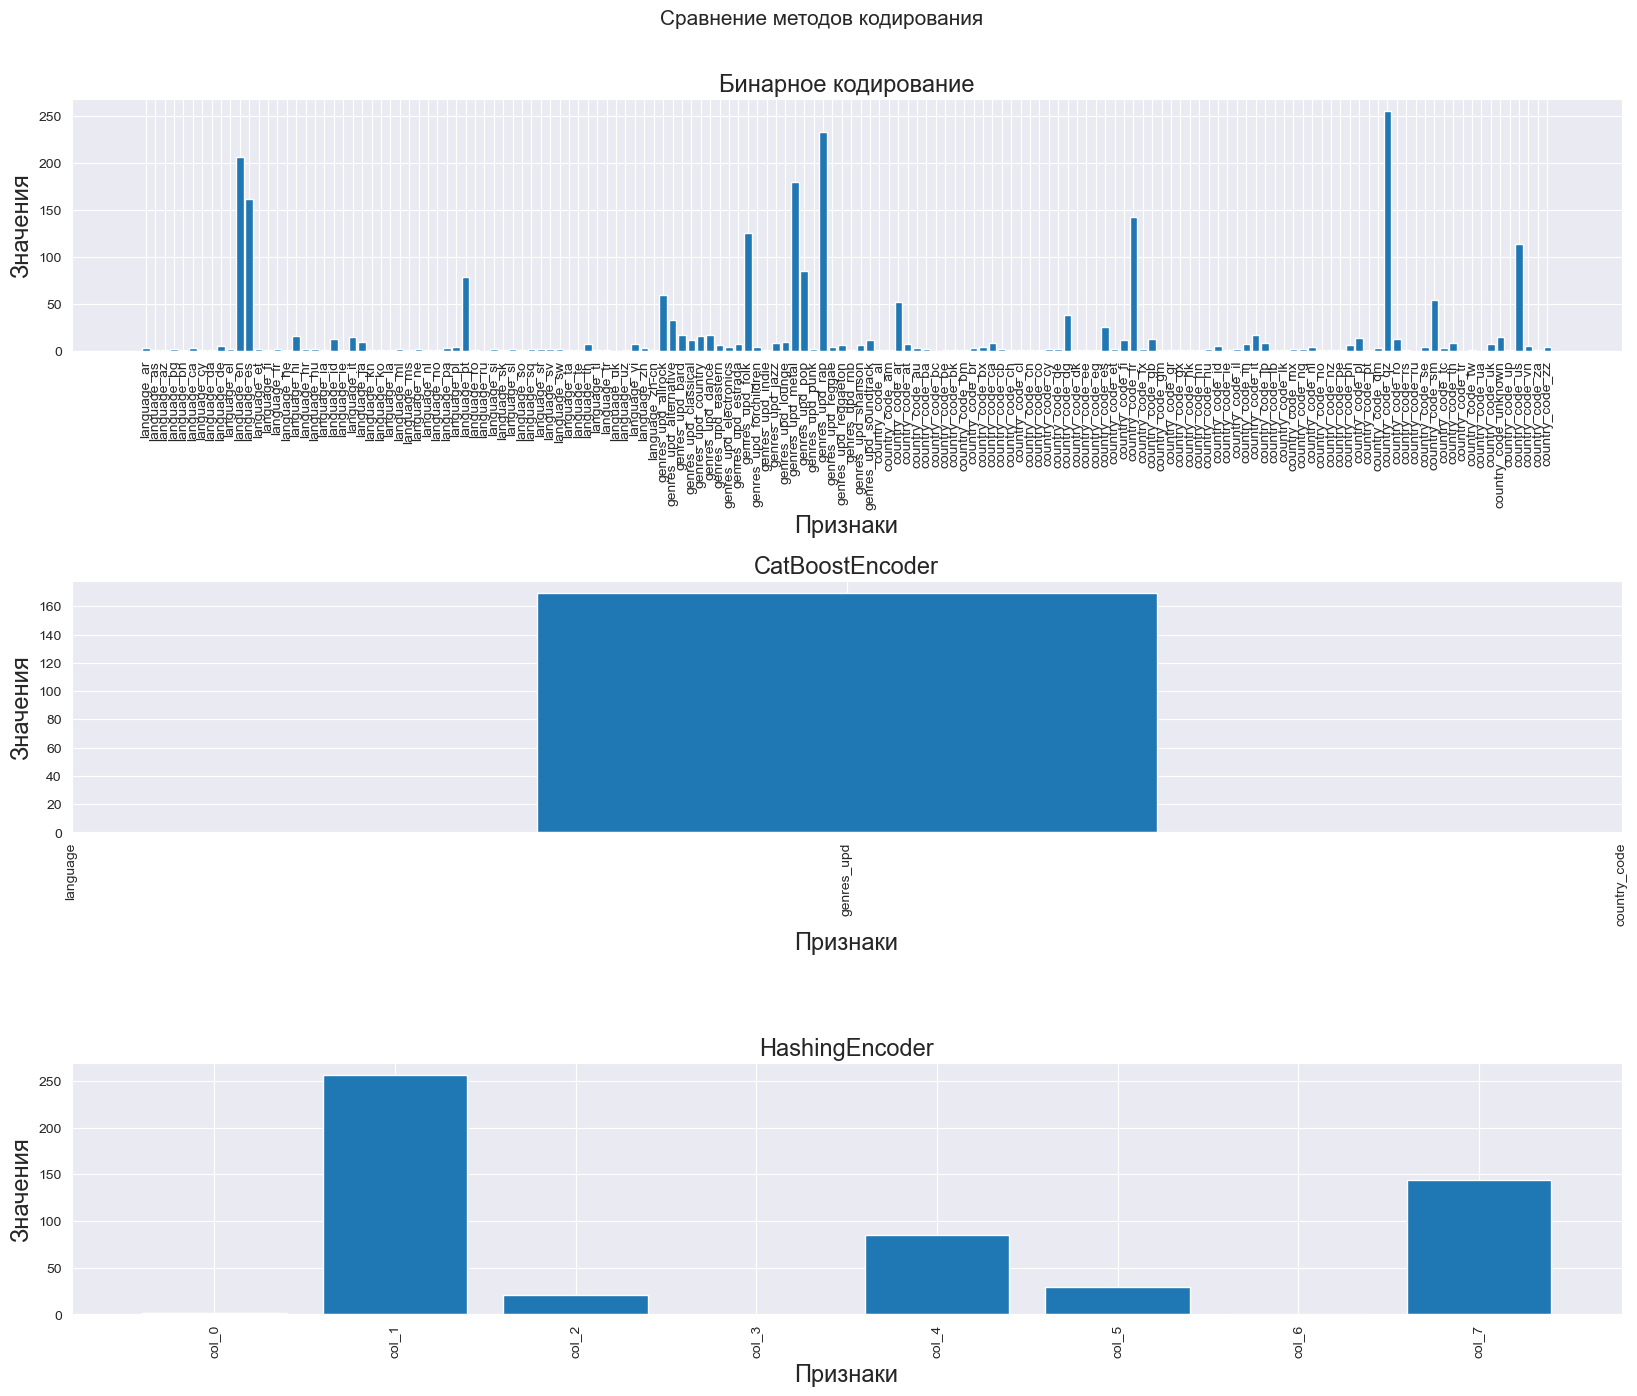

In [25]:
show_importance_for_cat_features()

 - Для категориальных:
   1. В случае бинарной классификации, каждое значение каждого признака транслировано в отдельный признак.
      На графике видно, что есть слабо значимые, и признаки с высоким показателем.
   2. Для CatBoostEncoder всего три признака, и только жанр значимый.
   3. Для HashingEncoder признаки разделились на 7 колонок. Три признака почти обнулились.
   
Лучший вариант - бинарное кодирование, т.к. это позволит в дальнейшем исключить слабозначимые признаки, и
не потерять более важные, как , например, с CatBoostEncoder (там язык исполнения практически обнулили).
Так же бинарное кодирование позволит интерпритировать значение признаков для модели, в отличие от HashingEncoder.
Для него названия признаков потеряли свою актуальность.

Что бы убедится наверняка, проверим метрики для каждого набора.

In [26]:
del show_importance_for_numeric_features, num_val_for_cat_features, get_df_by_coders, show_importance_for_cat_features

# Метрика и масштабизатор

В качестве метрики выберем:

 - F1-меру, что бы сохранить баланс между полнотой и точностью.
   При дисбалансе она поможет минизировать количество ложных срабатываний и ложных пропусков.
   
 - ROC_AUC - для оценки общего качества модели, и ее спосоности разделять на классы.

**В качестве масштабизатора выберем RobustScaler**

На этапе исследования было выявлено, что некоторые признаки содержат большой разброс.

Учитывая, что тексты мы будем преобразовывать в векторы, а значит и признаки тоже, то скорее всего наша будущая модель будет опираться на расстояние между точками данных (например, метод опорных векторов). Так же некоторые модели могут быть чувствительны к масштабу данных.

<u>Нормализация может помочь:</u> 
1. Уравнять масштаб признаков. Это предотвратит доминирование признаков с большими значениями над признаками с меньшими значениями.
2. Сделать интерпретацию и обучение более стабильными.
3. Ускорить сходимости алгоритмов оптимизации. 
4. Повысить производительность модели.

# Классификатор

Ниже ряд функций для визуализации.

In [27]:
def show_metrics(model, df, target=False) -> print:
    f1, auc_roc = None, None
    if target is not False:
        multi = cross_validate(model, df, target,
                               cv=10, scoring=('f1', 'roc_auc'))

    else:
        multi = cross_validate(model, 
                               df.drop(['track_remake_type'],axis=1),
                               df['track_remake_type'],
                               cv=10, scoring=('f1', 'roc_auc'))
    f1 = multi['test_f1'].mean()
    auc_roc = multi['test_roc_auc'].mean()
    print(f'Метрика: F1-{f1} | AUC_ROC-{auc_roc}')

In [28]:
def plot_features_importance(model, df, target=False) -> None:
    features_name, features, target = None, None, None
    if target:
        features = df.copy(deep=True)
        features_name = features.columns.tolist()
        target = target
    else:    
        features = df.drop(['track_remake_type'], axis=1)
        features_name = df.drop(['track_remake_type'], axis=1).columns.tolist()
        target = df['track_remake_type']
    model.fit(features, target)
    values = model.coef_.flatten()

    df = pd.DataFrame.from_dict({'Features': features_name,
                                 'Values': values})
    
    
    plt.figure(figsize=[35, 15])
    plt.title(f'Значение признаков для модели', fontsize=22)
    sns.barplot(data=df,
                x='Features', 
                y='Values',
                color='blue')
    plt.ylabel('Значение', fontsize=15)
    plt.xlabel('Признаки', fontsize=15)
    plt.xticks(rotation='vertical')
    plt.xticks(fontsize=15)
    plt.grid(True)

    plt.show(True);

In [29]:
def get_outliers(df: pd.core.frame.DataFrame, column: str) -> tuple:
    """Фукнция возвращает выбросы, первый и третий квартиль для диаграммы размаха."""
    q_one = df[column].quantile(q=.25)
    q_three  = df[column].quantile(q=.75)
    iqr = q_three - q_one
    left_border = q_one-(1.5*iqr)
    right_border = q_three+(1.5*iqr)
    outliers_left = df[df[column] < left_border]
    outliers_right = df[df[column] > right_border]
    full_outliers = len(outliers_left) + len(outliers_right)
    return(full_outliers, left_border, right_border)

In [30]:
def plot_charts(model, df:pd.core.frame.DataFrame, target=None) -> None:
    '''Функция строит гистограмму, диаграмму размаха для выбранного признака. 
    В легенде отображается значение для среднего, медианны, стандартного отклонения.'''
    if target:
        features = df.copy(deep=True)
        features_name = features.columns.tolist()
        target = target
    else:    
        features = df.drop(['track_remake_type'], axis=1)
        features_name = df.drop(['track_remake_type'], axis=1).columns.tolist()
        target = df['track_remake_type']
        
    model.fit(features, target)
    values = model.coef_.flatten()
    df_val = pd.DataFrame.from_dict({'Features': features_name,
                                     'Values': values})      
    


    outliers_full, left_border_full, right_border_full = get_outliers(df_val, 'Values')
    fig = plt.figure(figsize=[20, 15])
    grd = plt.GridSpec(ncols=1,nrows=2, top=0.92, wspace=0.15, hspace=0)
    plt.suptitle('Диаграмма размаха и гистограмма для значений модели', fontsize=17)
    
    fig_ax_1 = fig.add_subplot(grd[1,0])
    plt.grid(True)
    sns.set_style('darkgrid')
    hist = sns.histplot(data=df_val, x='Values',
                        multiple='stack', palette=['blue'], 
                        alpha=0.25, legend=False, kde=True,
                        linewidth=3)
    for line in hist.lines:
        line.set_linewidth(5)
    median_line_full_df = plt.axvline(np.median(df_val['Values']), 
                                         color='indigo', 
                                         linestyle='-',
                                         lw=2,   
                                         label=f'Median line of feature')
    left_border_line_full_df = plt.axvline(left_border_full, 
                                              color='m', 
                                              linestyle=':',
                                              lw=3,
                                              label=f'Первый квантиль')
    right_border_line_full_df = plt.axvline(right_border_full, 
                                               color='m', 
                                               linestyle='-.',
                                               lw=3,
                                               label=f'Третий  квантиль') 
    plt.xlabel('Значения', fontsize=15)
    plt.ylabel('Количество', fontsize=15)

    fig_ax_2 = fig.add_subplot(grd[0,0])
    ax = sns.boxplot(x='Values', data=df_val, palette=['blue'],
                     orient="h", showcaps=False, notch=True, medianprops={"color": "indigo"}, boxprops=dict(alpha=.5))
    mean_line_full_df = plt.axvline(np.mean(df_val['Values']), 
                                       color='black', 
                                       linestyle='--',
                                       lw=3,
                                       label=f'Линия среднего для признака')
    median_line_full_df = plt.axvline(np.median(df_val['Values']), 
                                      color='indigo', 
                                      linestyle='-',
                                      lw=3,   
                                      label='Медианная линия для признака')
    left_border_line_full_df = plt.axvline(left_border_full, 
                                           color='m', 
                                           linestyle=':',
                                           lw=3,
                                           label='Первый квантиль')
    right_border_line_full_df = plt.axvline(right_border_full, 
                                            color='m', 
                                            linestyle='-.',
                                            lw=3,
                                            label='Третий  квантиль') 
    plt.ylabel('Значения признаков', fontsize=15)
    plt.gca().axes.get_xaxis().set_visible(False)

    plt.legend(title=f'Легенда для значений признаков модели',
           handles=[Patch(color='blue', alpha=.5, label='Значения признаков модели'),
                    mean_line_full_df,
                    median_line_full_df,
                    left_border_line_full_df,
                    right_border_line_full_df,
                    Patch(color='none', label=f"Количество выбросов -{outliers_full:.2f}"),
                    Patch(color='none', label=f"Std value-{df_val['Values'].std():.2f}"),
                    Patch(color='none', label=f"Mean value-{np.mean(df_val['Values']):.2f}"),
                    Patch(color='none', label=f"Median value-{np.median(df_val['Values']):.2f}"),],
           
           edgecolor = 'r',
           facecolor = 'oldlace',
           ncol=3,
           title_fontsize=17,
           fontsize=15,
           loc='center',
           bbox_to_anchor=(0.5, -1.3));

## Отбор признаков

За базовую модель примем Логистическую регрессию.
Обучим ее на численных признаках и посморим на результат.

На дальнейшем пути улучшения качества будем отталкиваться от полученного результата.

In [31]:
def show_metrics_for_datasets(dct):
    for name, df in dct.items():
        multi = cross_validate(LogisticRegression(random_state=42),
                               df.drop(['track_remake_type'],axis=1),
                               df['track_remake_type'],
                               cv=10,
                               scoring=('f1', 'roc_auc'))

        print(f"{name}: F1-{multi['test_f1'].mean()} | AUC_ROC-{multi['test_roc_auc'].mean()}")
        print()

In [32]:
show_metrics_for_datasets({"Бинарное кодирование": df_cat_features_binary, 
                           "CatBoostEncoder": df_cat_features_cat, 
                           "HashingEncoder": df_cat_features_hash})

Бинарное кодирование: F1-0.8337908773885243 | AUC_ROC-0.9212784339431357

CatBoostEncoder: F1-0.8369047933785227 | AUC_ROC-0.923270517852129

HashingEncoder: F1-0.7441423830870832 | AUC_ROC-0.8059005628404858



Лучшие метрики у CatBoostEncoder, но не смотря на это, мы считаем, что бинарный метод даст больше вариантов для настройки модели.

Теперь объеденим наблюдения для численных признаков.

In [33]:
df_numeric_features = pd.get_dummies(df_numeric_features, columns=['language','genres_upd', 'country_code'],
                                     drop_first=True)

In [34]:
scaler = RobustScaler()
for col in df_numeric_features.drop(['track_remake_type'], axis=1).columns.tolist():
    df_numeric_features[col] = scaler.fit_transform(df_numeric_features[col].values.reshape(-1, 1))

In [35]:
show_metrics(LogisticRegression(random_state=42), df_numeric_features)

Метрика: F1-0.8511587286155535 | AUC_ROC-0.9323209688038524


Качество метрики улучшилось.

Рассмотрим значения признаков для модели

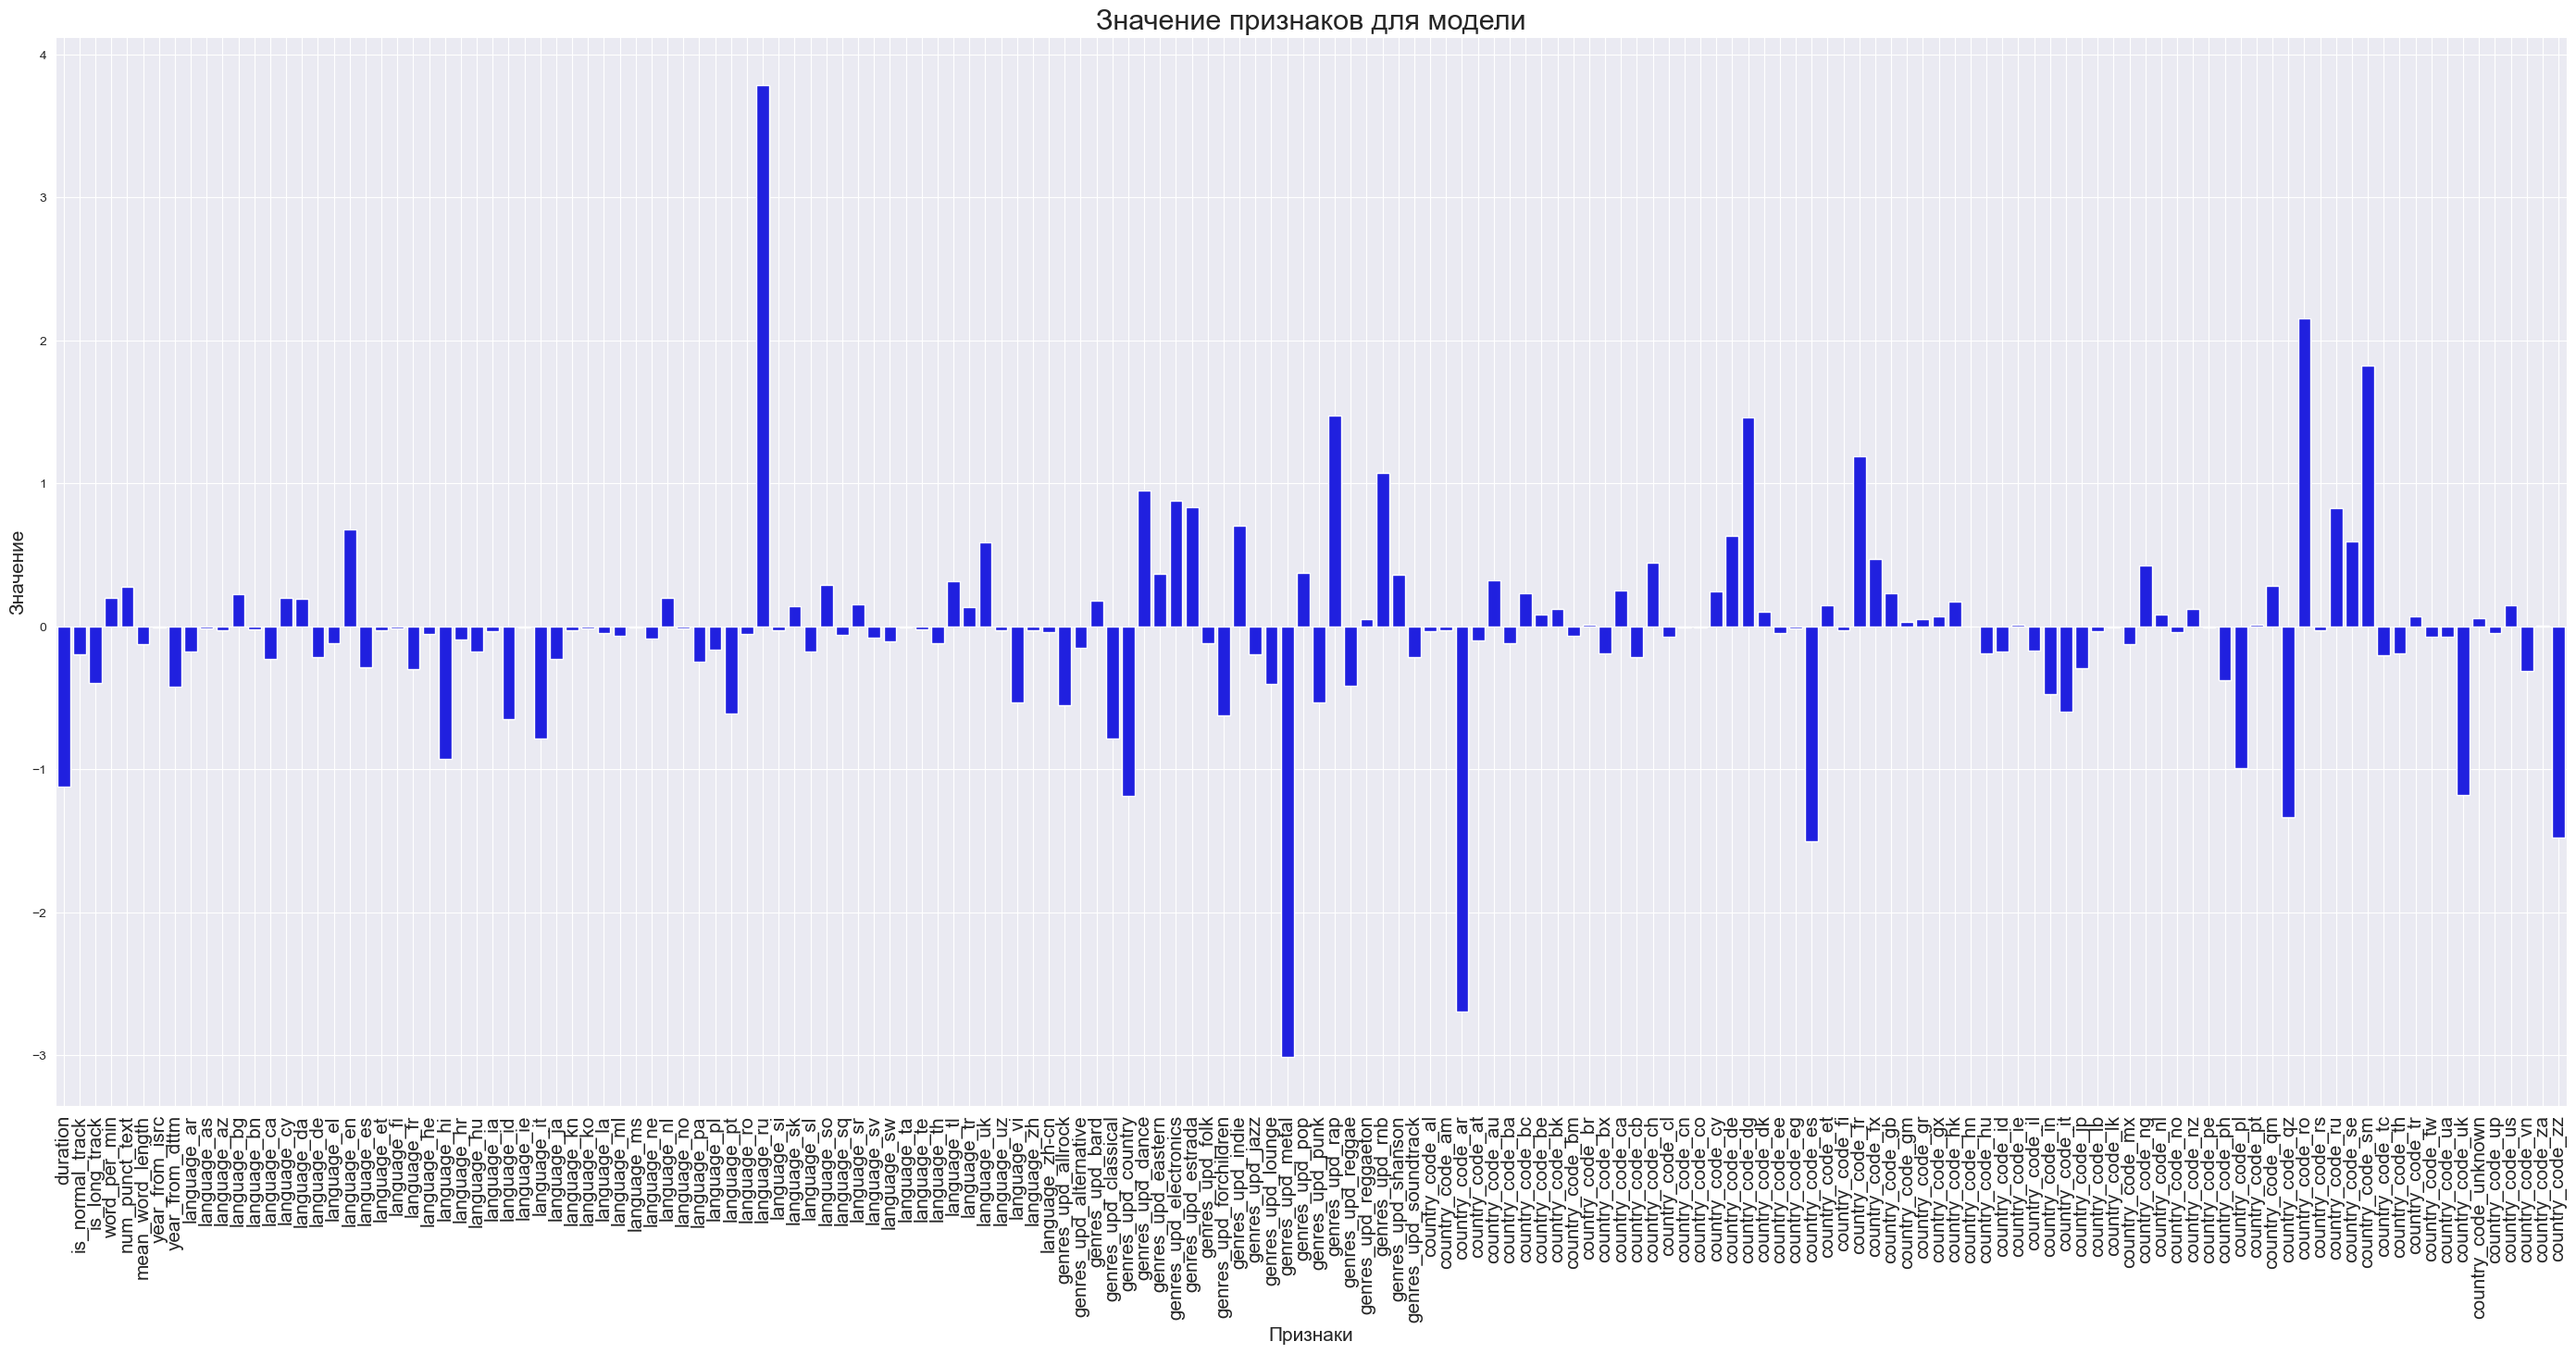

In [36]:
plot_features_importance(LogisticRegression(random_state=42), df_numeric_features)

Русский язык исполнения и жанр метал обладают высокой значимостью для модели.

А год регистрации слабозначимый.

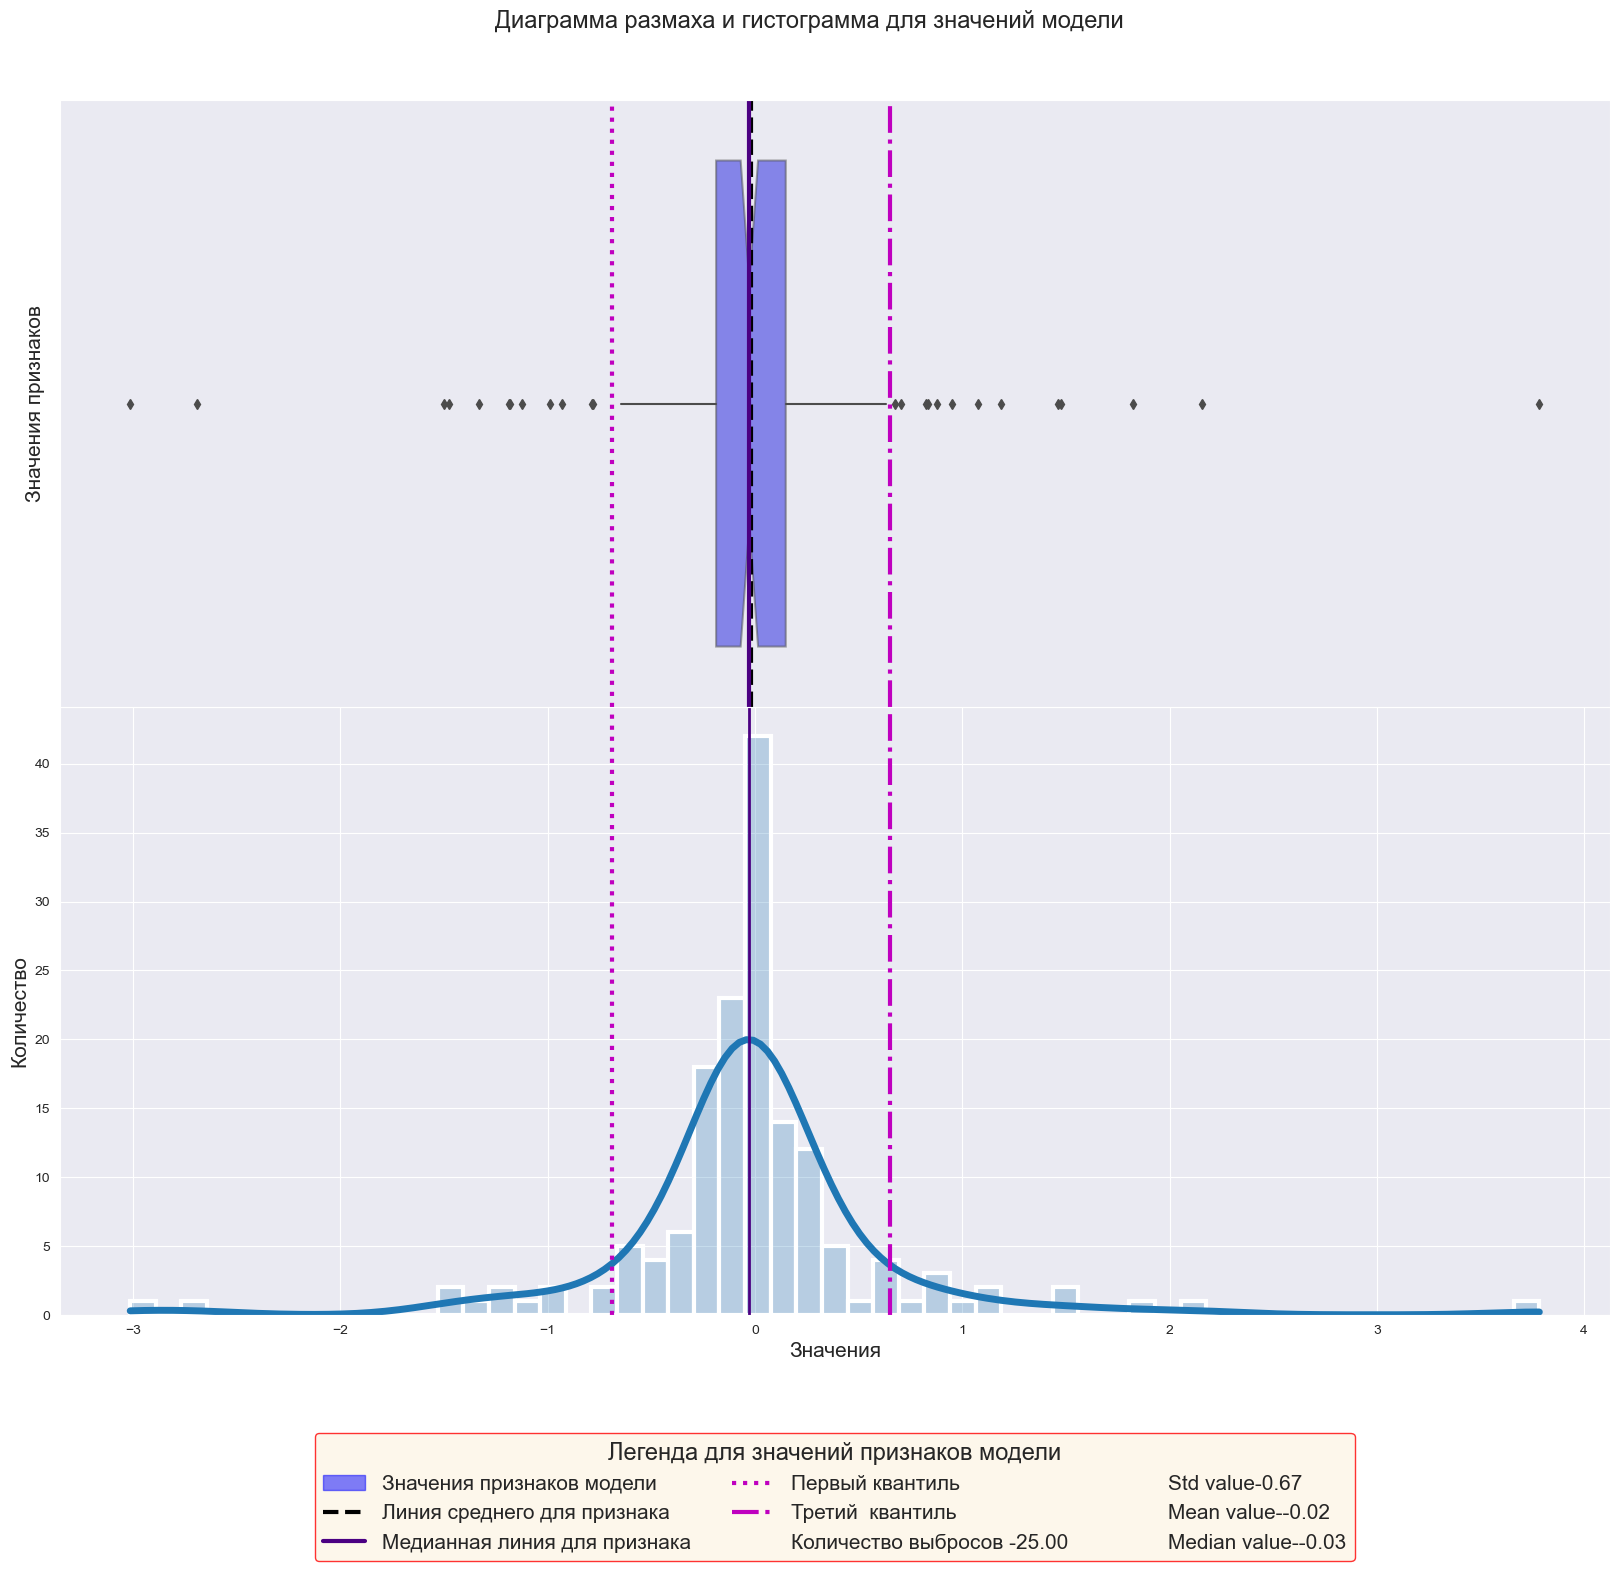

In [37]:
plot_charts(LogisticRegression(random_state=42), df_numeric_features)

После бинарного преобразования появились признаки , которые сильно влияют на модель, но так же есть и слабозначимые.

Попробуем отобрать лучшие признаки и отсеить не информативные с помощью SequentialFeatureSelector.

In [38]:
# sfs = SequentialFeatureSelector(estimator=LogisticRegression(random_state=42, solver='liblinear'),
#                                 k_features='best',
#                                 scoring='f1',
#                                 n_jobs=-1)

# sfs = sfs.fit(df_numeric_features.drop(['track_remake_type'], axis=1),
#               df_numeric_features['track_remake_type'])

# best_features = list(sfs.k_feature_names_)

In [39]:
# with open(cwd + "best_features.txt", "w") as output:
#     output.write(str(best_features))

In [40]:
# with open(cwd + "best_features.ob", 'wb') as fp:
#     pickle.dump(best_features, fp)

In [41]:
with open(cwd + "best_features.ob", "rb") as fp:
    best_features = pickle.load(fp)

In [42]:
show_metrics(LogisticRegression(random_state=42), df_numeric_features[best_features], 
             df_numeric_features['track_remake_type'])

Метрика: F1-0.8511179942223706 | AUC_ROC-0.9231787674227453


Метрика снова улучшилась.

In [43]:
del df_cat_features_binary, df_cat_features_cat, df_cat_features_hash, scaler, col

## Объединение датасета и тестирование базовой модели.

Объеденим корпус текста и названия песен с численными признаками.

In [44]:
target = data['track_remake_type']
df_numeric_features.drop(['track_remake_type'], axis=1, inplace=True)
df_numeric_features = df_numeric_features[best_features]

updated_text = csr_matrix(hstack([csr_matrix(corpus_text),  csr_matrix(corpus_title)]))
updated_data = csr_matrix(hstack([updated_text,  df_numeric_features.values]))

In [45]:
show_metrics(LogisticRegression(random_state=42), updated_data, target=target)

Метрика: F1-0.8782209888400712 | AUC_ROC-0.944721700331716


Векторы текстов так же улучшили метрику.

In [46]:
del df_numeric_features, updated_text, best_features

## Тестирование других моделей.

In [47]:
# %%time
# show_metrics(SVC(random_state=42, kernel='rbf'), updated_data, target=target)

In [55]:
%%time
show_metrics(xgb.XGBClassifier(objective='binary:logistic', random_state=42), 
             updated_data, target=target)

Метрика: F1-0.9275832157167638 | AUC_ROC-0.9761136367323194
CPU times: user 21min 35s, sys: 34 s, total: 22min 9s
Wall time: 3min 9s


Лучшие результаты у градиентного бустинга

## Порог классификации

Попробуем еще повысить качество модели, подобрав порог разделения на классы.

In [56]:
def plot_roc_curve(model, df, target):
    best_f1 = 0
    best_threshold = 0
    x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=42)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    probalities = model.predict_proba(x_test)
    probabilities_one = probalities[:,1]
    for threshold in np.arange(0.1, 0.9, 0.1):
        predicted_valid = probabilities_one > threshold
        f1 = f1_score(y_test, predicted_valid)
        if (f1 > best_f1):
            best_f1 = f1
            best_threshold = threshold
            if (best_threshold >= 0.1 ):
                min_boundary = best_threshold - 0.05
                max_boundary = best_threshold + 0.05
                for updated_threshold in np.arange(min_boundary, max_boundary, 0.01):
                    predicted_valid = probabilities_one > updated_threshold
                    f1 = f1_score(y_test, predicted_valid)
                    if (f1 > best_f1):
                        best_f1 = f1
                        best_threshold = updated_threshold
    predicted_valid = probabilities_one > best_threshold
    auc_roc = roc_auc_score(predictions, predicted_valid)
    fpr, tpr, all_thresholds = roc_curve(y_test, predicted_valid)
    
    plt.figure(figsize=[15, 7])
    plt.title('ROC-кривая', fontsize=15)
    plt.plot([0,1],[0,1], linestyle ='--', label='Константная модель')
    plt.text((fpr[1] + 0.02),(tpr[1] + 0.02), 
             f'Порог-{best_threshold:.2f}, FPR-{fpr[1]:.2f}, TPR-{tpr[1]:.2f}, F1-{best_f1:.4f}',
             color='r',
             fontsize=16)
    plt.plot(fpr[1],tpr[1], 
             'o',
             color='r',
             label=f'Порог - {best_threshold}', markersize=10)
    plt.axvline(x=fpr[1], color='r', linestyle='--')
    plt.axhline(y=tpr[1], color='r', linestyle='--')
    plt.plot(fpr, tpr, label=f'ROC-кривая')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.legend(edgecolor = 'r',
               facecolor = 'oldlace')
    plt.show()

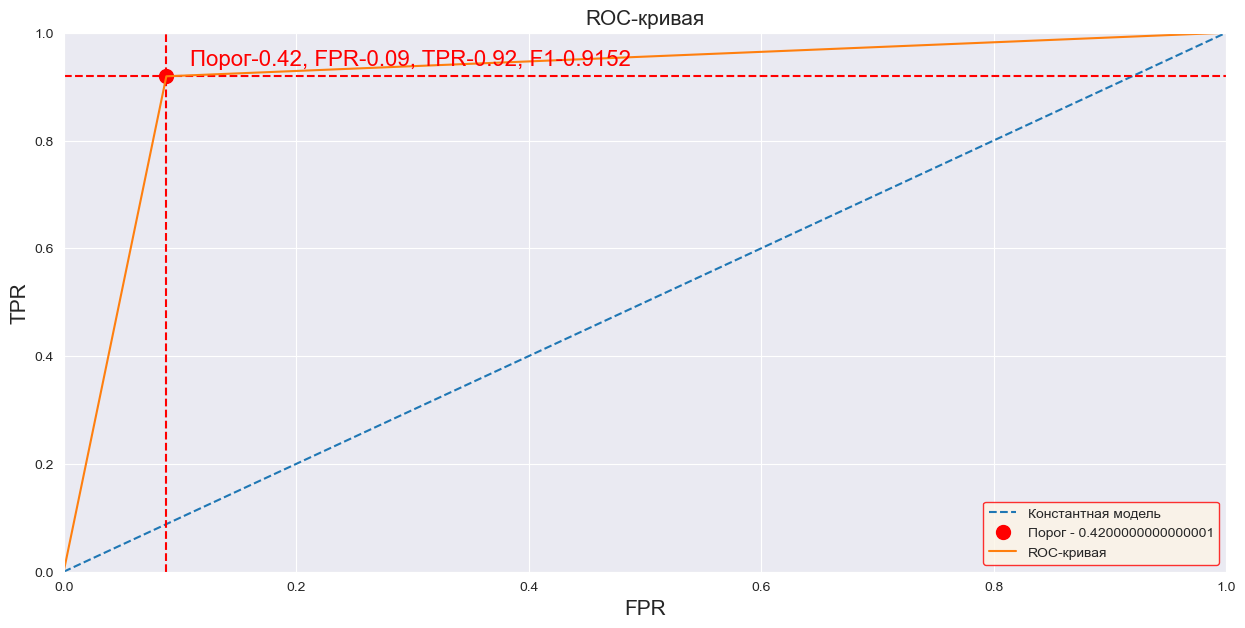

In [58]:
plot_roc_curve(xgb.XGBClassifier(objective='binary:logistic', random_state=42), updated_data, target=target)

Корректировка порога классифкации не улчшила метрику.

Сохраним датасет для  следующего этапа : "Поиск кцепочки".

In [59]:
def save_sparse_csr(filename: str, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

In [60]:
target.to_csv(cwd+'target.csv')
merge_data.to_csv(cwd+'merge_data_updated.csv')
save_sparse_csr(cwd+'updated_data.npz', updated_data)

In [63]:
del save_sparse_csr

# Отчет по разделу моделинг: Выбор классификатора

In [62]:
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
x_train, x_test, y_train, y_test = train_test_split(updated_data, target, test_size=0.33, random_state=42)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [66]:
pd.DataFrame(confusion_matrix(y_test, predictions),
             columns=['Кавер', 'Оригинал'],
             index = ['Кавер', 'Оригинал'])

,Кавер,Оригинал
Кавер,2146,186
Оригинал,213,2087


Модель обладает высоким качеством разделения на классы, и совершает минимум ложных срабатываний.

        В ходе работы:
        1. Произведена трансформация текстов и названий в векторное представление.
           Перед этим была произведена отчистка текста от символов и цифр.
           Для трансофрмации использовался Multi Universe Sentence Encoder.
           Мощный инструмент в области задач по обработке естественного языка.
        2. Произведен анализ значений признаков, численных и категориальных для того, чтобы
           выбрать подходящий метод кодировки с сохранением значимости признака.
           Сравнивалось три метода: бинарное кодирование, хэш-кодирование, кодирование на основе CatBoost.
           Решением стало бинарное кодирование, где каждое значение признака становится отделбьным бинарным 
           признаком. Не смотря на то, что такой подход значительно увеличивает признаковое пространство,
           в дальнейшем он позволил исключить слабозначимые признаки, и повысить качество модели.
        3. Для оценки модели взяты:
           - среднне гармоничное между полнотой и точностью,чтобы минимизировать количество ложных срабатываний,
           - roc_auc для того чтобы оценить разделяющую способность модели
        4. Исправлен дисбаланс целевого признака, путем увеличения в количестве примеров меньшего класса.
           Так же рассматривался метод уменьшения большего класса, но в связи с тем, что такой метод мог удалить 
           часть важной информации, он был отвергнут.
        5. Были выявлены наилучшие для модели признаки, и отсееены слабозначимые, оказывавшие отрицательное
           влияние на качество модели. Использовался SequentialFeatureSelector, последовательный отбор признаков.
           Такой метод более ресурсоемкий, но результат на выходе дал прирост к метрике.
        6. Для улучшения качества предсказаний векторные эмбединги и численные признаки были соеденены в один 
           набор.
        7. Для масштабирования данных выбран RobustScaler, он не боится выбросов и подходит для несимметричных 
           данных.
        8. Были рассмотрены несколько моделей классификации: логистическая регрессия, метод опорных векторов, 
           градиентный бустинг. Модели подбирались из соображения размера признакового пространства.
           Предварительно мы взяли за основу логистическую регрессию, и последовательно улучшали ее метрику.
           В финальной итерации сравнения бустинг показал лучшие качества и наилучшее время работы.
        9. Была сделана попытка подбора  порога разделения на классы, но качество метрики не улучшилось.
           
           
           
        В результате работы была выбрана наилучшая модель Градиентный бустинг, и достигнуто для нее высокое 
        качество классификации музыкальных треков на оригинал/кавер.